In [1]:
from input_pipeline import nmf_obj
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from textblob import TextBlob
from sklearn.cluster import KMeans
import seaborn as sns

import clean_filter_text as cft

In [2]:
reviews = pd.read_csv('../raw_data/deceptive-opinion.csv')
y = reviews['deceptive']
x = reviews.drop('deceptive', axis=1)
x_tv, x_te, y_tv, y_te = train_test_split(x, y, test_size=0.2, random_state=444)
x_tr, x_va, y_tr, y_va = train_test_split(x_tv, y_tv, test_size=0.25, random_state=444)

In [3]:
file_df = pd.read_pickle('../pickles/clean_hotel_reviews.pkl')

In [4]:
test_nmf = nmf_obj()
test_nmf.init_tfidf(ngram=(1,2))
test_nmf.init_tdm(file_df)
test_nmf.init_nmf(5)

In [5]:
test_nmf.display_topics()
display = test_nmf.export_topic_df()

         0          1              2         3          4
0    great      locat           view      walk      night
1    check       desk          night      time     servic
2     veri  room veri      veri nice     clean       nice
3      thi  thi hotel  recommend thi  stay thi  recommend
4  chicago   downtown          visit    luxuri    definit


In [7]:
def kmeans_cluster(k, data):
    km = KMeans(n_clusters=k, random_state=444)
    km.fit_predict(data)
    return km

In [8]:
def preserve_index(svd_df, old_idx_df):
    svd_df['og_index'] = old_idx_df.index
    return svd_df

In [9]:
def tb_subjectivity(text):
    sub_score = TextBlob(text).sentiment.subjectivity
    return sub_score

def tb_sentiment(text):
    pol_score = TextBlob(text).sentiment.polairty
    return 'negative' if pol_score < .3 else 'positive'

In [10]:
def add_features_to_topics(topic_df, x_sel, keep_text=False):
    '''
    Takes topic model matrix and adds subjectivity, review length, and dummifies polarity. Also
    adds original index as a column in the topic model matrix.
    '''
    topic_df = preserve_index(topic_df, x_sel)
    x_sel = preserve_index(x_sel, x_sel)
    x_mod = topic_df.merge(x_sel, how='left', on='og_index')
    x_mod.drop(['hotel', 'source', 'og_index'], axis=1, inplace=True)
    x_mod['tb_subjective'] = x_mod['text'].apply(tb_subjectivity)
    x_mod['review_length'] = x_mod['text'].apply(lambda x: len([x for x in x.split()]))
    x_mod['polarity'] = x_mod['polarity'].map({'negative':0, 'positive': 1})
    x_mod.index = x_sel.index
    if keep_text:
        return x_mod
    else:
        return x_mod.drop('text', axis=1)

In [11]:
bigram_add_feat = add_features_to_topics(display, x_tr, True)

<ipython-input-8-940e5000a4af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svd_df['og_index'] = old_idx_df.index


In [12]:
bigram_add_feat

,"great,locat,view,walk,night","check,desk,night,time,servic","veri,room veri,veri nice,clean,nice","thi,thi hotel,recommend thi,stay thi,recommend","chicago,downtown,visit,luxuri,definit",polarity,text,tb_subjective,review_length
118,0.073043,0.065412,0.028582,0.042986,0.088793,1,Our third stay at the Homewood Suites Chicago ...,0.487235,184
49,0.140194,0.056084,0.000000,0.004602,0.027383,1,The concierge was so helpful. Without hesitati...,0.573214,125
980,0.002089,0.129239,0.000000,0.000000,0.002188,0,I wrote an email to the sales & reservation te...,0.300000,61
60,0.192980,0.000000,0.064174,0.000000,0.045297,1,Great hotel in heart of Chicago for business o...,0.556409,63
804,0.000000,0.143329,0.000000,0.016703,0.000000,0,They allowed parties to go on all night and bo...,0.511905,165
...,...,...,...,...,...,...,...,...,...
1032,0.031053,0.000000,0.085187,0.104728,0.024398,0,I'm sitting in the hotel as I right this revie...,0.462747,128
1546,0.000000,0.063713,0.002669,0.206772,0.012342,0,This hotel is dizzying with all of the bold co...,0.510185,148
1429,0.005864,0.129928,0.000000,0.107837,0.000000,0,when we arrived the check in process was fairl...,0.468519,106
464,0.032819,0.002181,0.000000,0.053641,0.153236,1,While travelling for business I had my family...,0.620714,101


In [13]:
scaler = StandardScaler()
x_feat_sc = scaler.fit_transform(bigram_add_feat.drop('text', axis=1))

In [14]:
true_k=9
bigram_plus_cluster = kmeans_cluster(true_k, x_feat_sc)
bigram_add_feat['cluster'] = bigram_plus_cluster.labels_
bigram_add_feat['target'] = y_tr

In [16]:
bigram_add_feat[bigram_add_feat['cluster'] == 7]

,"great,locat,view,walk,night","check,desk,night,time,servic","veri,room veri,veri nice,clean,nice","thi,thi hotel,recommend thi,stay thi,recommend","chicago,downtown,visit,luxuri,definit",polarity,text,tb_subjective,review_length,cluster,target
174,0.046146,0.034048,0.021056,0.051939,0.074981,1,My girlfriends and I stayed 4 nights at the Ta...,0.621190,110,7,truthful
175,0.044899,0.000000,0.074572,0.000000,0.089219,1,"Excellent location, about a block from Michiga...",0.750000,39,7,truthful
220,0.044449,0.034260,0.023639,0.010799,0.097913,1,We loved our stay at the Talbott. We were in C...,0.582222,102,7,truthful
755,0.007631,0.000000,0.000000,0.060829,0.160014,1,The Palmer House Hilton hotel takes luxury to ...,0.470110,106,7,deceptive
653,0.045222,0.011182,0.003435,0.000000,0.171199,1,My family chose to stay at the Chicago Hilton ...,0.597436,114,7,deceptive
...,...,...,...,...,...,...,...,...,...,...,...
1562,0.003995,0.040478,0.034481,0.025826,0.159652,0,This hotel was very overpriced for what you ge...,0.569120,125,7,deceptive
514,0.006613,0.017064,0.000000,0.108499,0.117099,1,"When my sister got married last summer, our st...",0.568056,101,7,deceptive
643,0.000000,0.000000,0.032951,0.074229,0.124343,1,The stay at the Hilton Chicago definetely felt...,0.720000,56,7,deceptive
756,0.000000,0.076350,0.032138,0.000000,0.123667,1,My husband and I recently chose the Palmer Hou...,0.538889,173,7,deceptive


In [17]:
bigram_add_feat[bigram_add_feat['cluster'] == 7].target.value_counts()

deceptive    117
truthful      22
Name: target, dtype: int64

In [24]:
bigram_add_feat[bigram_add_feat['cluster'] == 7].describe()

,"great,locat,view,walk,night","check,desk,night,time,servic","veri,room veri,veri nice,clean,nice","thi,thi hotel,recommend thi,stay thi,recommend","chicago,downtown,visit,luxuri,definit",polarity,tb_subjective,review_length,cluster
count,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.0
mean,0.025736,0.019300,0.031884,0.028945,0.142932,0.920863,0.592162,111.431655,7.0
std,0.028029,0.021654,0.036251,0.033425,0.033635,0.270928,0.093651,47.204312,0.0
min,0.000000,0.000000,0.000000,0.000000,0.062223,0.000000,0.380000,30.000000,7.0
25%,0.000000,0.000000,0.000000,0.000000,0.115699,1.000000,0.526042,75.000000,7.0
50%,0.018560,0.013595,0.015048,0.013274,0.142811,1.000000,0.580952,103.000000,7.0
75%,0.040434,0.033725,0.053379,0.050384,0.167697,1.000000,0.651698,132.500000,7.0
max,0.130183,0.087947,0.139929,0.117925,0.221129,1.000000,0.816667,272.000000,7.0


In [18]:
bigram_add_feat[bigram_add_feat['cluster'] == 7].loc[755,'text']

"The Palmer House Hilton hotel takes luxury to a whole new level of existence. The rooms are beautifully decorated, with class and superior quality furniture. The hotels restaurant 'lockwood' consist's of delicious French and Italian cuisine. The location is in the prime area to downtown, and shopping areas. This hotel is suited for pristine guests, and those who are not willing to settle for less. If you're looking for not just any stay, but a stay in luxury, you should give The Palmer House Hilton a try. It is one of the best of the best in Chicago, and your stay will be one to remember.\n"

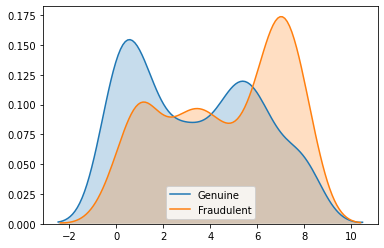

In [19]:
sns.kdeplot(bigram_add_feat[bigram_add_feat['target'] == 'truthful'].cluster, 
            shade=True, label='Genuine')
sns.kdeplot(bigram_add_feat[bigram_add_feat['target'] == 'deceptive'].cluster, 
            shade=True, label='Fraudulent')

In [23]:
# cluster 0 is subjectivity front desk service
# cluster 1 is subjectivity good location
# cluster 2 is subjectivity front desk service
# cluster 3 is sentiment polarity good location
# cluster 4 is review length high recommendation
# cluster 5 is sentiment polarity urban luxury
# cluster 6 is review length front desk service
# cluster 7 is sentiment polarity cleanliness

bigram_plus_cluster.cluster_centers_

array([[ 1.94672111e+00, -7.86449958e-01, -2.49726923e-02,
        -2.49744782e-01, -3.17475332e-01,  9.30648687e-01,
         6.42124555e-01, -5.16050817e-01],
       [-5.55484211e-01,  7.83028444e-01, -3.92551898e-01,
        -4.75740357e-01, -4.30493500e-01, -9.59202881e-01,
        -1.17347756e+00,  3.28799171e-02],
       [-1.55608512e-01, -9.38214960e-01,  2.59120606e+00,
        -3.76243427e-01, -1.69713930e-01,  7.14659332e-01,
         6.30005957e-01, -6.31751845e-01],
       [-4.52148998e-01,  7.11056642e-02, -8.30919811e-02,
         1.42113969e+00, -5.13968748e-01, -9.44700802e-01,
        -3.56545980e-01,  7.68190968e-02],
       [ 1.28107339e-01, -1.00301836e+00,  2.50031757e-01,
         1.72134744e+00,  2.55219851e-01,  1.01469124e+00,
         7.86268765e-01, -5.81161459e-01],
       [ 3.72299197e-01,  1.90227417e-03,  5.62515361e-02,
        -3.95806881e-01,  2.25858058e-02,  1.01469124e+00,
        -2.51999447e-01,  2.39408632e-01],
       [-3.09956223e-01,  5.263490

In [22]:
list(bigram_add_feat.columns)

['great,locat,view,walk,night',
 'check,desk,night,time,servic',
 'veri,room veri,veri nice,clean,nice',
 'thi,thi hotel,recommend thi,stay thi,recommend',
 'chicago,downtown,visit,luxuri,definit',
 'polarity',
 'text',
 'tb_subjective',
 'review_length',
 'cluster',
 'target']

In [26]:
xva_df = cft(x_va)

AttributeError: module 'clean_filter_text' has no attribute 'clean_main'

In [25]:
xva_nmf = nmf_obj()
xva_nmf.init_tfidf(ngram=(1,2))
xva_nmf.init_tdm(file_df)
xva_nmf.init_nmf(5)

,hotel,polarity,source,text
317,sofitel,positive,TripAdvisor,I read the reviews on Trip Advisor for this pr...
394,intercontinental,positive,TripAdvisor,We stayed at the Intercontinental for three ni...
91,knickerbocker,positive,TripAdvisor,I loved this hotel - fabulous old building but...
66,fairmont,positive,TripAdvisor,We recently completed our second stay at the F...
1138,allegro,negative,Web,Me and my husband stayed in the Allegro Hotel ...
...,...,...,...,...
786,palmer,positive,MTurk,The Palmer House Hilton in Chicago is by far t...
1067,hilton,negative,Web,The hotel is very impressive upon entering and...
46,hyatt,positive,TripAdvisor,I stayed here for business and loved it. Got i...
785,amalfi,positive,MTurk,I recently stayed at the Amalfi Chicago with m...
